## Assignment Information

| Field | Details |
|-------|---------|
| **Name** | Pros Loung |
| **Course** | AAI-521 Applied Computer Vision for AI |
| **Assignment** | 3.1 - Object Detection and Segmentation |
| **GitHub Repository** | https://github.com/ploung/AAI-521-ComputerVision_Module3.git |

---

### Assignment Overview


In [3]:
# Import necessary libraries
# ! Install tensorflow-datasets if not already installed
# !pip install tensorflow-hub
import tensorflow_hub as hub
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pylab as plt
import numpy as np
import cv2

In [8]:
# a) Load the oxford_iiit_pet dataset

dataset, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True)
train_ds = dataset['train']
test_ds = dataset['test']

# Explore the dataset
print(info) 
print(f"Number of training samples: {len(train_ds)}")
print(f"Number of test samples: {len(test_ds)}")

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='C:\\Users\\Loung\\tensorflow_datasets\\oxford_iiit_pet\\4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'la

Training Dataset Samples:
Displaying 3: images


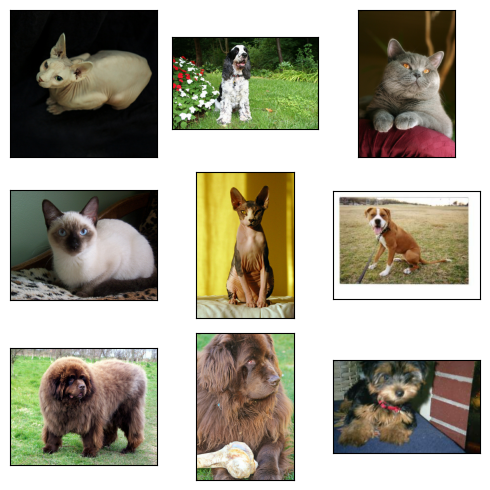

Testing Dataset Samples:
Displaying 3: images


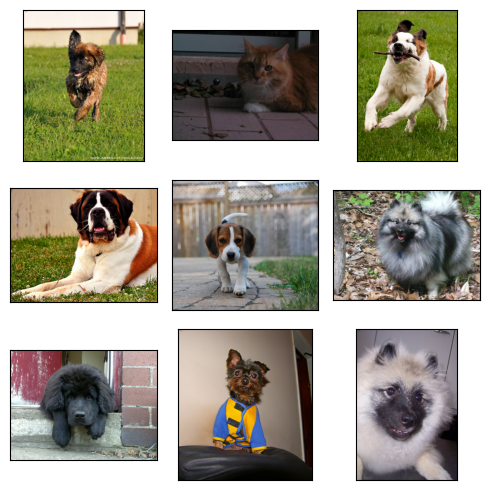

In [9]:
# Visualize some images from the dataset 
ImageLabel = info.features['label'].names

def ShowImage(ImageData, NumImg=2):
    '''Displays the first number of images from the dataset.'''
    print(f'Displaying {NumImg}: images')
    plt.figure(figsize=(5, 5))
    for i in range(NumImg * NumImg):
        plt.subplot(NumImg, NumImg, i + 1)
        plt.xticks([])  
        plt.yticks([])  
        plt.grid(False)
        plt.imshow(ImageData[i], cmap=plt.cm.binary)
        #plt.xlabel([ImageLabel[i]])
    plt.tight_layout()
    plt.show()

train_dataset = dataset['train']
test_dataset = dataset['test']

print("Training Dataset Samples:")
ShowImage([data['image'].numpy().squeeze() for data in train_dataset.take(9)], NumImg=3)

print("Testing Dataset Samples:")
ShowImage([data['image'].numpy().squeeze() for data in test_dataset.take(9)], NumImg=3)

In [10]:
def read_and_preprocess(data):
    input_image = data['image']  
    input_mask = data['segmentation_mask']
    
    # Resize images to 128x128
    input_image = tf.image.resize(input_image, [128, 128])
    input_mask = tf.image.resize(input_mask, [128, 128])
    
    # ! Important: Proper image normalization for display
    #input_image = tf.image.convert_image_dtype(input_image, tf.float32) # [0,1]
    #input_mask -= 1 # {1,2,3} to {0,1,2}
    input_image = tf.cast(input_image, tf.float32) / 255.0  # Normalize to [0,1]
    
    # ? Process mask properly
    input_mask = tf.cast(input_mask, tf.float32)
    input_mask -= 1  # {1,2,3} to {0,1,2}
    
    return input_image, input_mask

In [ ]:
train = dataset['train'].map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(read_and_preprocess)

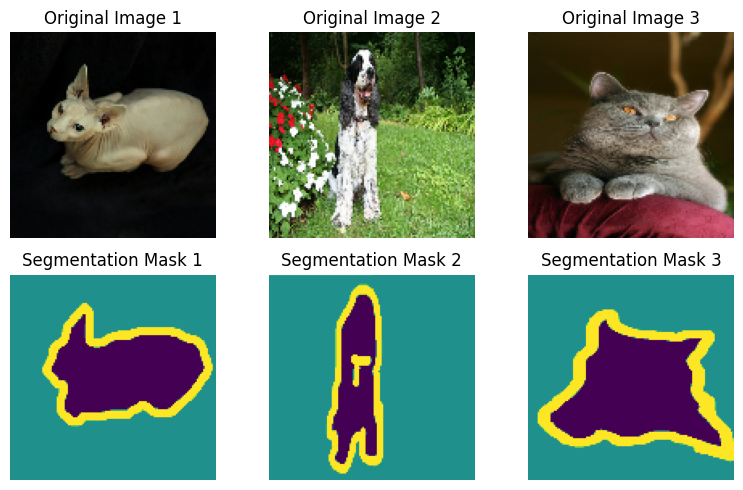

In [ ]:
# b) Create the segmentation mask
# Show some images from dataset and their segmented version

images, masks = next(iter(train.batch(3)))

# Create a 2x3 subplot layout: images on top row, masks on bottom row
plt.figure(figsize=(8, 5))

# Display the original images on the top row
for i in range(3):
    plt.subplot(2, 3, i+1)  
    plt.imshow(images[i])
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

# Display the masks on the bottom row
for i in range(3):
    plt.subplot(2, 3, i+4)  
    plt.imshow(masks[i], cmap='viridis')  
    plt.title(f'Segmentation Mask {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()

**Part 2- Annotation**

In [ ]:
# Install mrcnn if not already installed
#!pip install mrcnn

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for mrcnn: filename=mrcnn-0.2-py3-none-any.whl size=54962 sha256=25d7ab246c7112eb7de7702f06ab806acdb0f30bc9bb0db5042a8faafbf87272
  Stored in directory: c:\users\loung\appdata\local\pip\cache\wheels\78\48\79\befdb05914fe17ed22535bc6e0e8f93ce4730aa90aca603270
Successfully built mrcnn


In [ ]:
# Get data from here https://github.com/experiencor/raccoon_dataset
# Uncomment to clone git repo
# !git clone https://github.com/experiencor/raccoon_dataset

In [ ]:
# Load dataset and plot some sample images

import os

def load_images(dataset_path='None'):
    """Create method images from the dataset directory"""
    images_path = os.path.join(dataset_path, 'images')
    image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    images = []
    image_names = []
    
    for image_file in image_files:
        image_path = os.path.join(images_path, image_file)
        
        # Load image using OpenCV
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        images.append(image)
        image_names.append(image_file)
    
    print(f"Loaded {len(images)} images")
    return images, image_names

def plot_sample_images(images, num_images=6):
    """Create method to plot sample images from the dataset"""
    plt.figure(figsize=(8, 5))
    for i in range(num_images):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Image {i + 1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Loaded 200 images


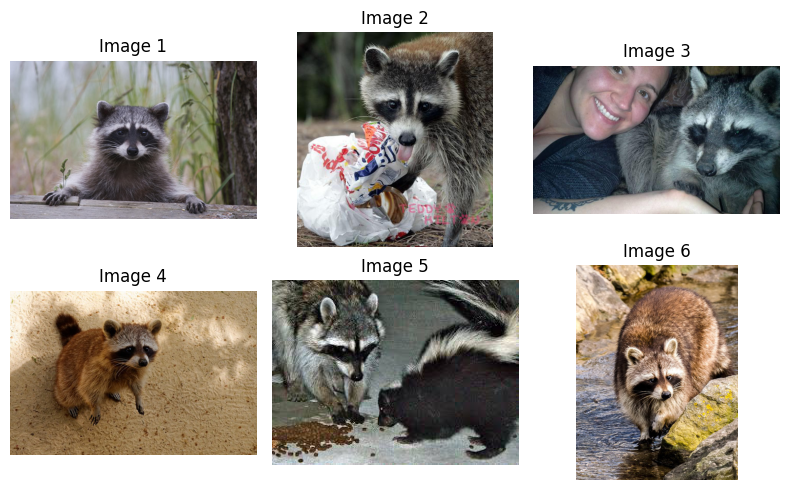

In [22]:
# Load the Raccoon dataset images
images, names = load_images('raccoon_dataset')

# Plot sample images from the Raccoon dataset
plot_sample_images(images, num_images=6)